In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from tensorflow.keras import models
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception, EfficientNetB7
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D,LSTM
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir('/content/drive/MyDrive/Datasets/X_Rays_CTs_2Class_Updated')
NORMAL=os.listdir('/content/drive/MyDrive/Datasets/X_Rays_CTs_2Class_Updated/Normal')
COVID=os.listdir('/content/drive/MyDrive/Datasets/X_Rays_CTs_2Class_Updated/COVID')

data=np.concatenate([NORMAL,COVID])
len(data)==len(COVID)+len(NORMAL) 

True

In [ ]:
np.size(COVID)

4868

In [ ]:
np.size(NORMAL)

11421

In [ ]:
target_x=np.full(len(NORMAL),0)
target_y=np.full(len(COVID),1)
data_target=np.concatenate([target_x,target_y])
len(data_target)==len(target_x)+len(target_y)

True

In [ ]:
X_data = []
for file in NORMAL:
    
    img = cv2.imread('/content/drive/MyDrive/Datasets/X_Rays_CTs_2Class_Updated/Normal/'+file)
    face = cv2.resize(img, (224, 224) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
   
    X_data.append(img)

In [ ]:
np.save('/content/drive/MyDrive/Datasets/X_Rays_CTs_2Class_Updated/Normal', X_data, allow_pickle=True, fix_imports=True)

In [ ]:
COVID_data=[]

In [ ]:
for file in COVID:
    
    img = cv2.imread('/content/drive/MyDrive/Datasets/X_Rays_CTs_2Class_Updated/COVID/'+file)
    face = cv2.resize(img, (224, 224) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    COVID_data.append(img)
    X_data.append(img)
  
len(X_data)

16289

In [ ]:
np.save('/content/drive/MyDrive/Datasets/X_Rays_CTs_2Class_Updated/COVID', COVID_data, allow_pickle=True, fix_imports=True)

In [ ]:
N_data= np.load('/content/drive/MyDrive/Datasets/X_Rays_CTs_2Class_Updated/Normal.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
C_data= np.load('/content/drive/MyDrive/Datasets/X_Rays_CTs_2Class_Updated/COVID.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
X_data = np.concatenate([N_data,C_data])

In [ ]:
X = np.squeeze(X_data)

In [ ]:
# normalize data
X = X.astype('float16')
X /= 255


In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X,data_target, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)


In [ ]:
print(X_train.shape, X_test.shape,X_valid.shape, y_train.shape,y_valid.shape, y_test.shape)

(13031, 224, 224, 3) (1629, 224, 224, 3) (1629, 224, 224, 3) (13031,) (1629,) (1629,)


In [ ]:
N_data=C_data=X_data=X=[]

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:

#from d2l import tensorflow as d2l

class Residual(tf.keras.Model):  
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 =  tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)


In [ ]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU
from keras.layers import LeakyReLU
from keras.optimizers import rmsprop_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
hidden_unit = 32
kernel_size = 3
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same' , activation ='relu',input_shape = (224,224,3)))
model.add(BatchNormalization())

model.add(ResnetBlock(64, 2, first_block=True))
model.add(ResnetBlock(64, 2, first_block=True))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(128, 2))
model.add(ResnetBlock(128, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(256, 2))
model.add(ResnetBlock(256, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(1,2), strides=(1,2)))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(GRU(hidden_unit,return_sequences=True)))
model.add(Flatten())
model.add(Dense(256 , activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1, activation = "sigmoid"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 resnet_block (ResnetBlock)  (None, 224, 224, 64)      148736    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 224, 224, 64)     148736    
 )                                                               
                                                                 
 batch_normalization_9 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [ ]:
file_path = os.path.join('/content/drive/MyDrive/Models', 'Twoclass_Residual-Bi-GRU_without_KFold(Updated-DATASET)', 'TwoCLass.h5')
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10, verbose = 1, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
ckp = ModelCheckpoint(filepath= file_path,monitor = 'val_loss',
                      verbose = 1, save_best_only = True, mode = 'min', save_weights_only = True)

In [ ]:
fit_history = model.fit(X_train,
                        y_train,
                        batch_size = 8,
                        shuffle = True,
                        epochs = 50,
                        #initial_epoch=10,
                        validation_data = (X_valid,y_valid),
                        callbacks=[rlr,ckp])
        

Epoch 1/50
1629/1629 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.6675
Epoch 00001: val_loss improved from inf to 0.41550, saving model to /content/drive/MyDrive/Models/Twoclass_Residual-Bi-GRU_without_KFold(Updated-DATASET)/TwoCLass.h5
1629/1629 [==============================] - 277s 156ms/step - loss: 0.6435 - accuracy: 0.6675 - val_loss: 0.4155 - val_accuracy: 0.8128 - lr: 0.0010
Epoch 2/50
1629/1629 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7645
Epoch 00002: val_loss improved from 0.41550 to 0.33839, saving model to /content/drive/MyDrive/Models/Twoclass_Residual-Bi-GRU_without_KFold(Updated-DATASET)/TwoCLass.h5
1629/1629 [==============================] - 250s 154ms/step - loss: 0.4954 - accuracy: 0.7645 - val_loss: 0.3384 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 3/50
1629/1629 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8008
Epoch 00003: val_loss improved from 0.33839 to 0.30876, saving model t

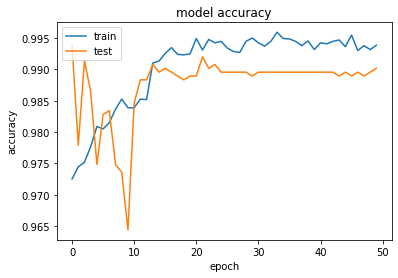

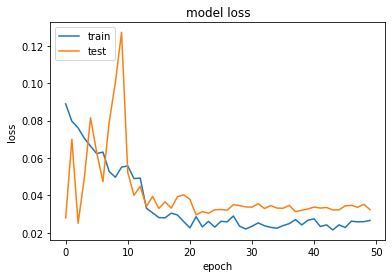

In [ ]:
# summarize history for accuracy
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Evaluation on Testing Data**

In [ ]:
#prediction on test data
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
# for sigmoid
y_pred =[]
pred=model2.predict(X_test, batch_size=1)
for x in pred:
  if x > 0.5:
   y_pred.append(1)
  else:
   y_pred.append(0)
y_pred=np.array(y_pred)
acc = accuracy_score(y_test,y_pred)
print("\nEvaluation on test data: ", acc * 100)


Evaluation on test data:  99.50890116635973


In [ ]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score

#actual =  valid_data.labels
preds = np.argmax(model2.predict(X_test), axis=1)
cfmx = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test,y_pred)
print ('Test Accuracy:', acc )
print('Confusion matrix:', cfmx)

Test Accuracy: 0.9950890116635973
Confusion matrix: tf.Tensor(
[[1148    1]
 [   7  473]], shape=(2, 2), dtype=int32)


In [ ]:
score = model2.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

Test loss: 0.01581624150276184
Test accuracy: 99.50889945030212


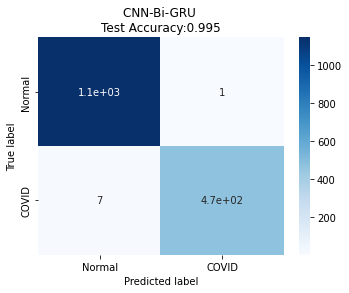

In [ ]:
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Normal','COVID'], 
                     columns = ['Normal','COVID'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('CNN-Bi-GRU \nTest Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1149
           1       1.00      0.99      0.99       480

    accuracy                           1.00      1629
   macro avg       1.00      0.99      0.99      1629
weighted avg       1.00      1.00      1.00      1629



In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision = precision_score(y_test, y_pred, average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: %.3f' % recall)
score = f1_score(y_test, y_pred, average='weighted')
print('F-Measure: %.3f' % score)

Precision: 0.995
Recall: 0.995
F-Measure: 0.995


In [ ]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [ ]:
confusion_metrics(cm)

True Positives: 473
True Negatives: 1148
False Positives: 1
False Negatives: 7
--------------------------------------------------
Accuracy: 1.0
Mis-Classification: 0.0
Sensitivity: 0.99
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.99


# **Cross Data Validation :  External Cohort**

In [ ]:
img_size = 224
batch_size = 1
train_data_dir='/content/drive/MyDrive/Datasets/Curated X-Ray Dataset/2 class'

train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.1) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 5464 images belonging to 2 classes.
Found 607 images belonging to 2 classes.


In [ ]:
validation_generator.class_indices

{'0-Normal': 0, '1-COVID-19': 1}

In [ ]:

#from d2l import tensorflow as d2l

class Residual(tf.keras.Model):  
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 =  tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)


In [ ]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU
from keras.layers import LeakyReLU
from keras.optimizers import rmsprop_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
hidden_unit = 32
kernel_size = 3
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same' , activation ='relu',input_shape = (224,224,3)))
model.add(BatchNormalization())

model.add(ResnetBlock(64, 2, first_block=True))
model.add(ResnetBlock(64, 2, first_block=True))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(128, 2))
model.add(ResnetBlock(128, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(256, 2))
model.add(ResnetBlock(256, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(1,2), strides=(1,2)))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(GRU(hidden_unit,return_sequences=True)))
model.add(Flatten())
model.add(Dense(256 , activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1, activation = "sigmoid"))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_29 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 resnet_block_6 (ResnetBlock  (None, 224, 224, 64)     148736    
 )                                                               
                                                                 
 resnet_block_7 (ResnetBlock  (None, 224, 224, 64)     148736    
 )                                                               
                                                                 
 batch_normalization_38 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                     

In [ ]:
model.load_weights('/content/drive/MyDrive/Models/Twoclass_Residual-Bi-GRU_without_KFold(Updated-DATASET)/TwoCLass.h5')

In [ ]:
#prediction on test data
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
actual =  validation_generator.labels
# for sigmoid
y_pred =[]
pred=model.predict(validation_generator, batch_size=1)
for x in pred:
  if x > 0.5:
   y_pred.append(1)
  else:
   y_pred.append(0)
y_pred=np.array(y_pred)
acc = accuracy_score(actual,y_pred)
print("\nEvaluation on External test data: ", acc * 100)


Evaluation on External test data:  92.09225700164745


In [ ]:
cfmx = confusion_matrix(actual, y_pred)
acc = accuracy_score(actual, y_pred)
print ('Cross Dataset Test Accuracy:', acc )
print('Confusion matrix:', cfmx)

Cross Dataset Test Accuracy: 0.9209225700164745
Confusion matrix: tf.Tensor(
[[327   0]
 [ 48 232]], shape=(2, 2), dtype=int32)


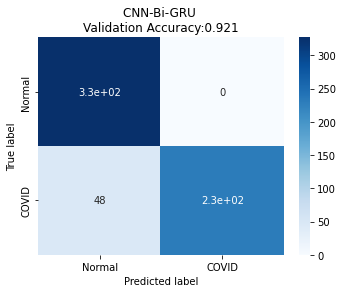

In [ ]:
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


# Creates a confusion matrix
cm = confusion_matrix(actual, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Normal','COVID'], 
                     columns = ['Normal','COVID'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('CNN-Bi-GRU \nValidation Accuracy:{0:.3f}'.format(accuracy_score(actual, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual,y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       327
           1       1.00      0.83      0.91       280

    accuracy                           0.92       607
   macro avg       0.94      0.91      0.92       607
weighted avg       0.93      0.92      0.92       607



In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision = precision_score(actual, y_pred, average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(actual, y_pred, average='weighted')
print('Recall: %.3f' % recall)
score = f1_score(actual, y_pred, average='weighted')
print('F-Measure: %.3f' % score)

Precision: 0.931
Recall: 0.921
F-Measure: 0.920


In [ ]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [ ]:
confusion_metrics(cm)

True Positives: 232
True Negatives: 327
False Positives: 0
False Negatives: 48
--------------------------------------------------
Accuracy: 0.92
Mis-Classification: 0.08
Sensitivity: 0.83
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.91
